In [1]:
!pip install 'accelerate>=0.26.0'
!pip install bitsandbytes
!pip install transformers|
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 124.2 MB/s eta 0:00:0000:0100:01
/bin/sh: -c: line 1: syntax error: unexpected end of file
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 144.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Tuple, List, Generator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss, confusion_matrix, classification_report
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from dataclasses import dataclass
from torch.utils.data import Dataset, IterableDataset
from tqdm import tqdm
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    AdamW, 
    get_linear_schedule_with_warmup,
    AutoModelForSequenceClassification,
    AutoConfig,
    BitsAndBytesConfig,
    EarlyStoppingCallback,
    TrainerCallback
)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
# Model Configuration
@dataclass
class ModelConfig:
    model_name: str = "Qwen/Qwen2.5-0.5B"
    # model_name: str = "Qwen/Qwen2.5-1.5B"
    # model_name: str = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" 
    max_length: int = 2048
    batch_size: int = 64
    learning_rate: float = 1e-4
    warmup_ratio: float = 0.1
    num_epochs: int = 4
    max_steps= 400
    warmup_steps: int = 100
    weight_decay: float = 0.01
    output_dir: str = "outputs"
    gradient_accumulation_steps: int = 2
    logging_steps: int = 25
    save_steps: int = 100
    eval_steps: int = 100
    torch_dtype: str = "bfloat16"  # change from "bfloat16" to "float16"
    use_flash_attention: bool = True

In [4]:
def evaluate_and_visualize(trainer, dataset, dataset_name=""):
    # Get predictions
    predictions = trainer.predict(dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print(f"\nClassification Report - {dataset_name}")
    print(classification_report(true_labels, pred_labels))
    
    return predictions.metrics


# Dataset Processing
class DatasetProcessor:
    def __init__(self, tokenizer_name: str, max_length: int, drop_long_sequences: bool = False):
        """
        Initialize DatasetProcessor with option to drop long sequences
        
        Args:
            tokenizer_name (str): Name of the tokenizer to use
            max_length (int): Maximum sequence length
            drop_long_sequences (bool): If True, drop samples exceeding max_length
        """
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.separator = "\n\n###\n\n"
        self.drop_long_sequences = drop_long_sequences
    
    def construct_prompt(self, row: pd.Series) -> str:
        return f"{row['prompt']}{self.separator}{row['response_a']}{self.separator}{row['response_b']}{self.separator}Choose which model response is preferred:"
    
    def get_label(self, row: pd.Series) -> int:
        return 2 if row['winner_tie'] == 1 else (1 if row['winner_model_b'] == 1 else 0)
    
    def check_sequence_length(self, prompt: str) -> bool:
        """
        Check if the sequence length is within the maximum limit
        
        Args:
            prompt (str): The input prompt to check
            
        Returns:
            bool: True if sequence is within limit, False otherwise
        """
        tokens = self.tokenizer(prompt, truncation=False)['input_ids']
        return len(tokens) <= self.max_length
    
    
    def pre_tokenize_data(self, df: pd.DataFrame) -> List[Dict[str, torch.Tensor]]:
        tokenized_data = []
        
        # Create a tqdm progress bar
        progress_bar = tqdm(
            total=len(df), 
            desc="Tokenizing Dataset", 
            unit="sample",
            dynamic_ncols=True
        )
        
        for _, row in df.iterrows():
            prompt = self.construct_prompt(row)
            label = self.get_label(row)
            
            encoding = self.tokenizer(
                prompt,
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            
            tokenized_data.append({
                "input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "labels": torch.tensor(label, dtype=torch.long)
            })
            
            # Update progress bar
            progress_bar.update(1)
            
            # Optional: Add some metadata to the progress bar
            progress_bar.set_postfix({
                'prompt_length': len(prompt),
                'input_ids_shape': encoding["input_ids"].shape
            })
        
        # Close the progress bar
        progress_bar.close()
        
        return tokenized_data

class PreTokenizedDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data
    
    def __len__(self):
        return len(self.tokenized_data)
    
    def __getitem__(self, idx):
        return self.tokenized_data[idx]

class PreTokenizedDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data
    
    def __len__(self):
        return len(self.tokenized_data)
    
    def __getitem__(self, idx):
        item = self.tokenized_data[idx]
        # Squeeze out unnecessary dimensions
        return {
            'input_ids': item['input_ids'].squeeze(),
            'attention_mask': item['attention_mask'].squeeze(),
            'labels': item['labels'].squeeze()
        }


def load_model(model_name: str, torch_dtype: str):  # Removed rope_scaling argument
    """Loads the model with 8-bit quantization and flash attention (if available)."""

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Use 4-bit instead of 8-bit
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

    # bnb_config = BitsAndBytesConfig(
    # load_in_8bit=True,  # Use 8-bit instead of 4-bit
    # bnb_8bit_compute_dtype=torch.bfloat16
    # )


    model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # 3-class classification
    torch_dtype=torch.bfloat16, 
    # quantization_config=bnb_config,
    )
    
    # model = prepare_model_for_kbit_training(model)
    model.to("cuda")
    model.gradient_checkpointing_enable()
    # model.gradient_checkpointing_disable()
    return model

def apply_peft_with_dora(model):
    """
    Apply DoRA (Decoupled LoRA) using PEFT for fine-tuning the quantized model.
    """
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,  # Increased rank
        lora_alpha=16,
        lora_dropout=0.05,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Added k_proj and o_proj
        init_lora_weights="gaussian"  # Better initialization
    )
    
    model = get_peft_model(model, lora_config)
    # Manually initialize LoRA weights
    for name, module in model.named_modules():  
        if "lora_A" in name and "default" in name:  
            nn.init.xavier_uniform_(module.weight) 
        elif "lora_B" in name and "default" in name:  
            nn.init.zeros_(module.weight)
    
    model.print_trainable_parameters()  # Ensure correct setup
    return model



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Apply label smoothing
    smoothed_labels = torch.zeros_like(torch.tensor(logits))
    smoothed_labels.scatter_(1, torch.tensor(labels).unsqueeze(1), 1)
    smoothed_labels = smoothed_labels * 0.9 + 0.1 / smoothed_labels.size(1)
    
    # Compute loss with label smoothing
    loss = F.cross_entropy(
        torch.tensor(logits), 
        smoothed_labels,
        reduction='mean'
    ).item()
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'cross_entropy_loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [5]:
# Training Setup
config = ModelConfig()
tokenizer = AutoTokenizer.from_pretrained(config.model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # ✅ Use EOS as padding token
model = load_model(config.model_name, config.torch_dtype)
model.config.pad_token_id = tokenizer.pad_token_id  # ✅ Ensure model recognizes it
model = apply_peft_with_dora(model)

# Make the classification head trainable
for name, param in model.named_parameters():
    if "score" in name:
        param.requires_grad = True
        # print(f"Trainable: {name}")

# Ensure all LoRA parameters are trainable
for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True
        # print(f"Ensuring trainability: {name}")

# Verify trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} / {total_params} ({trainable_params/total_params*100:.2f}%)")

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen2.5-0.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,084,032 || all params: 495,119,488 || trainable%: 0.2189
Trainable params: 1086720 / 495119488 (0.22%)


In [6]:
dataset_processor = DatasetProcessor(config.model_name, config.max_length)

In [7]:
dataset_processor = DatasetProcessor(config.model_name, config.max_length)
df = pd.read_csv("data/train.csv")
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)

# #sample
# train_df = train_df.iloc[1100:1200]
# val_df = val_df.head(100)
# test_df = test_df.head(100)

# Pre-tokenize the data
train_tokenized = dataset_processor.pre_tokenize_data(train_df)
val_tokenized = dataset_processor.pre_tokenize_data(val_df)
test_tokenized = dataset_processor.pre_tokenize_data(val_df)

# Create PyTorch datasets
train_dataset = PreTokenizedDataset(train_tokenized)
eval_dataset = PreTokenizedDataset(val_tokenized)
test_dataset = PreTokenizedDataset(test_tokenized)

Tokenizing Dataset: 100%|██████████| 4311/4311 [00:20<00:00, 210.29sample/s, prompt_length=4928, input_ids_shape=torch.Size([1, 2048])] 


In [8]:
training_args = TrainingArguments(
    output_dir=config.output_dir,
    num_train_epochs=config.num_epochs,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    logging_steps=config.logging_steps,
    save_steps=config.save_steps,
    warmup_ratio=config.warmup_ratio,
    lr_scheduler_type="cosine_with_restarts",
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    eval_strategy="steps",  # Evaluate every epoch
    save_strategy="steps",  # Save every epoch
    eval_steps=config.eval_steps,
    max_steps=config.max_steps,
    bf16=True,
    fp16=False,
    # gradient_checkpointing=False,
    save_total_limit=2,
    dataloader_num_workers=4,
    remove_unused_columns=False,
    logging_dir=f"{config.output_dir}/logs",
    logging_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_cross_entropy_loss",
    greater_is_better=False,
    max_grad_norm=0.5,
    group_by_length=True,
    bf16_full_eval=True,
    # lr_scheduler_type="cosine",
)

In [9]:
class SimpleLoggingCallback(TrainerCallback):
    def __init__(self, log_file=None):
        self.log_file = log_file
        self.log_entries = []

    def _log(self, message):
        print(message)
        if self.log_file:
            self.log_entries.append(message)

    def on_train_begin(self, args, state, control, **kwargs):
        self._log("\n--- Training Started ---")
        self._log(f"Total Training Steps: {state.max_steps}")
        self._log(f"Batch Size: {args.per_device_train_batch_size}")
        self._log(f"Gradient Accumulation Steps: {args.gradient_accumulation_steps}")
        self._log(f"Learning Rate: {args.learning_rate}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            log_str = " | ".join([f"{k}: {v:.4f}" for k, v in logs.items() if isinstance(v, (int, float))])
            self._log(f"Step {state.global_step}: {log_str}")

    def on_train_end(self, args, state, control, **kwargs):
        self._log("\n--- Training Completed ---")
        if self.log_file:
            with open(self.log_file, 'w') as f:
                f.write("\n".join(self.log_entries))

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations to wait for improvement
    early_stopping_threshold=0.01  # Minimum change to qualify as an improvement
)

class GradientLoggingCallback(TrainerCallback):
    def on_step_end(self, args, state, control, model=None, **kwargs):
        total_norm = 0.0
        for name, p in model.named_parameters():
            if p.requires_grad and p.grad is not None:
                total_norm += p.grad.data.norm(2).item() ** 2
        total_norm = total_norm ** 0.5
        print(f"Step {state.global_step} - Gradient Norm: {total_norm:.4f}")


class VerboseGradientLoggingCallback(TrainerCallback):
    def on_step_end(self, args, state, control, model=None, **kwargs):
        total_norm = 0.0
        max_norm = 0.0
        for name, p in model.named_parameters():
            if p.requires_grad and p.grad is not None:
                param_norm = p.grad.data.norm(2).item()
                total_norm += param_norm ** 2
                max_norm = max(max_norm, param_norm)
                
                # Detailed logging for LoRA and score parameters
                if "lora" in name or "score" in name:
                    print(f"{name} - Grad Norm: {param_norm:.6f}")
        
        total_norm = total_norm ** 0.5
        print(f"Step {state.global_step} - Total Gradient Norm: {total_norm:.4f}, Max Norm: {max_norm:.4f}")
ƒ
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() 
                   if p.requires_grad and ("lora" in n or "score" in n)],
        "lr": config.learning_rate * 8,  # e.g., 10x higher for LoRA/head
        "weight_decay": config.weight_decay
    },
    {
        "params": [p for n, p in model.named_parameters() 
                   if p.requires_grad and ("lora" not in n and "score" not in n)],
        "lr": config.learning_rate,
        "weight_decay": 0.0,
    },
]

optimizer = AdamW(optimizer_grouped_parameters, 
                  lr=config.learning_rate, 
                  betas=(0.9, 0.999),
                  eps=1e-8, 
                  correct_bias=True)

# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=config.warmup_steps,
#     num_training_steps=training_args.max_steps,
# )

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),  # Use our custom optimizer and scheduler
    callbacks=[early_stopping_callback, GradientDiagnosticCallback, SimpleLoggingCallback(log_file=f"{config.output_dir}/training_log.txt")]
)

In [11]:
torch.cuda.empty_cache()
trainer.train()


--- Training Started ---
Total Training Steps: 400
Batch Size: 64
Gradient Accumulation Steps: 2
Learning Rate: 0.0001


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss,Cross Entropy Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second,Steps Per Second
100,1.220200,1.129801,1.135357,0.398747,0.459583,0.398747,0.336340,239.231000,18.020000,0.284000
200,1.110600,1.171709,1.178256,0.389469,0.604092,0.389469,0.306476,238.893800,18.046000,0.285000
300,1.063000,1.029510,1.042931,0.468569,0.479805,0.468569,0.451392,238.956500,18.041000,0.285000
400,1.022000,1.012569,1.029379,0.494549,0.492071,0.494549,0.489417,238.907500,18.045000,0.285000



Step 25:
Total Gradient Norm: 0.0000
Step 25: loss: 1.7327 | grad_norm: 127.5998 | learning_rate: 0.0005 | epoch: 0.0654

Step 50:
Total Gradient Norm: 0.0000
Step 50: loss: 1.4087 | grad_norm: 48.8651 | learning_rate: 0.0008 | epoch: 0.1309

Step 75:
Total Gradient Norm: 0.0000
Step 75: loss: 1.2117 | grad_norm: 10.9230 | learning_rate: 0.0008 | epoch: 0.1963

Step 100:
Total Gradient Norm: 0.0000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step 100: loss: 1.2202 | grad_norm: 17.0910 | learning_rate: 0.0007 | epoch: 0.2618
Step 100: eval_loss: 1.1298 | eval_cross_entropy_loss: 1.1354 | eval_accuracy: 0.3987 | eval_precision: 0.4596 | eval_recall: 0.3987 | eval_f1: 0.3363 | eval_runtime: 239.2310 | eval_samples_per_second: 18.0200 | eval_steps_per_second: 0.2840 | epoch: 0.2618

Step 125:
Total Gradient Norm: 0.0000
Step 125: loss: 1.1820 | grad_norm: 27.9020 | learning_rate: 0.0007 | epoch: 0.3272

Step 150:
Total Gradient Norm: 0.0000
Step 150: loss: 1.1549 | grad_norm: 14.5365 | learning_rate: 0.0006 | epoch: 0.3927

Step 175:
Total Gradient Norm: 0.0000
Step 175: loss: 1.1354 | grad_norm: 14.7437 | learning_rate: 0.0006 | epoch: 0.4581

Step 200:
Total Gradient Norm: 0.0000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step 200: loss: 1.1106 | grad_norm: 25.7244 | learning_rate: 0.0005 | epoch: 0.5236
Step 200: eval_loss: 1.1717 | eval_cross_entropy_loss: 1.1783 | eval_accuracy: 0.3895 | eval_precision: 0.6041 | eval_recall: 0.3895 | eval_f1: 0.3065 | eval_runtime: 238.8938 | eval_samples_per_second: 18.0460 | eval_steps_per_second: 0.2850 | epoch: 0.5236

Step 225:
Total Gradient Norm: 0.0000
Step 225: loss: 1.0948 | grad_norm: 5.3063 | learning_rate: 0.0004 | epoch: 0.5890

Step 250:
Total Gradient Norm: 0.0000
Step 250: loss: 1.0599 | grad_norm: 7.3149 | learning_rate: 0.0003 | epoch: 0.6545

Step 275:
Total Gradient Norm: 0.0000
Step 275: loss: 1.0613 | grad_norm: 8.8985 | learning_rate: 0.0002 | epoch: 0.7199

Step 300:
Total Gradient Norm: 0.0000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step 300: loss: 1.0630 | grad_norm: 3.5175 | learning_rate: 0.0001 | epoch: 0.7853
Step 300: eval_loss: 1.0295 | eval_cross_entropy_loss: 1.0429 | eval_accuracy: 0.4686 | eval_precision: 0.4798 | eval_recall: 0.4686 | eval_f1: 0.4514 | eval_runtime: 238.9565 | eval_samples_per_second: 18.0410 | eval_steps_per_second: 0.2850 | epoch: 0.7853

Step 325:
Total Gradient Norm: 0.0000
Step 325: loss: 1.0251 | grad_norm: 2.1096 | learning_rate: 0.0001 | epoch: 0.8508

Step 350:
Total Gradient Norm: 0.0000
Step 350: loss: 1.0328 | grad_norm: 6.4460 | learning_rate: 0.0000 | epoch: 0.9162

Step 375:
Total Gradient Norm: 0.0000
Step 375: loss: 1.0140 | grad_norm: 4.3691 | learning_rate: 0.0000 | epoch: 0.9817

Step 400:
Total Gradient Norm: 0.0000


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step 400: loss: 1.0220 | grad_norm: 2.2826 | learning_rate: 0.0000 | epoch: 1.0471
Step 400: eval_loss: 1.0126 | eval_cross_entropy_loss: 1.0294 | eval_accuracy: 0.4945 | eval_precision: 0.4921 | eval_recall: 0.4945 | eval_f1: 0.4894 | eval_runtime: 238.9075 | eval_samples_per_second: 18.0450 | eval_steps_per_second: 0.2850 | epoch: 1.0471
Step 400: train_runtime: 12152.8384 | train_samples_per_second: 4.2130 | train_steps_per_second: 0.0330 | total_flos: 225672868089298944.0000 | train_loss: 1.1581 | epoch: 1.0471

--- Training Completed ---


TrainOutput(global_step=400, training_loss=1.1580684566497803, metrics={'train_runtime': 12152.8384, 'train_samples_per_second': 4.213, 'train_steps_per_second': 0.033, 'total_flos': 2.2567286808929894e+17, 'train_loss': 1.1580684566497803, 'epoch': 1.0471204188481675})

In [12]:
eval_results = trainer.evaluate()
print(f"Final evaluation results: {eval_results}")
trainer.save_model(f"{config.output_dir}/final_model")
tokenizer.save_pretrained(f"{config.output_dir}/final_model")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Step 400: eval_loss: 1.0124 | eval_cross_entropy_loss: 1.0292 | eval_accuracy: 0.4957 | eval_precision: 0.4934 | eval_recall: 0.4957 | eval_f1: 0.4906 | eval_runtime: 220.3176 | eval_samples_per_second: 19.5670 | eval_steps_per_second: 0.3090 | epoch: 1.0471
Final evaluation results: {'eval_loss': 1.012424111366272, 'eval_cross_entropy_loss': 1.0292150974273682, 'eval_accuracy': 0.4957086522848527, 'eval_precision': 0.4934497465613974, 'eval_recall': 0.4957086522848527, 'eval_f1': 0.4905915827112744, 'eval_runtime': 220.3176, 'eval_samples_per_second': 19.567, 'eval_steps_per_second': 0.309, 'epoch': 1.0471204188481675}


('outputs/final_model/tokenizer_config.json',
 'outputs/final_model/special_tokens_map.json',
 'outputs/final_model/vocab.json',
 'outputs/final_model/merges.txt',
 'outputs/final_model/added_tokens.json',
 'outputs/final_model/tokenizer.json')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating validation dataset...


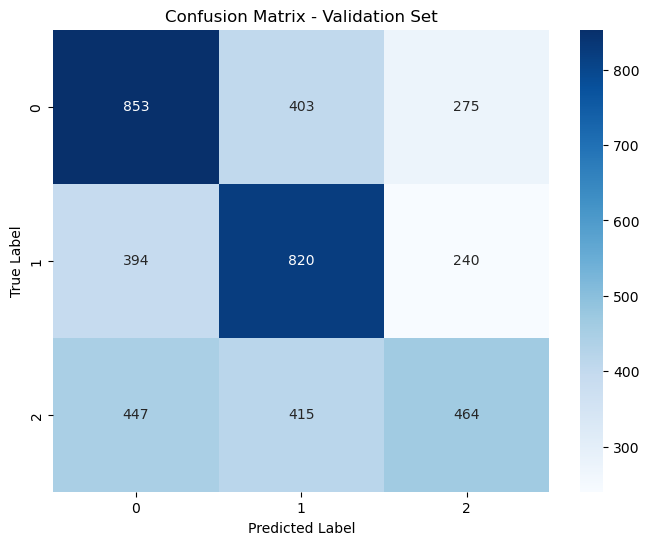

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Classification Report - Validation Set
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      1531
           1       0.50      0.56      0.53      1454
           2       0.47      0.35      0.40      1326

    accuracy                           0.50      4311
   macro avg       0.49      0.49      0.49      4311
weighted avg       0.49      0.50      0.49      4311


Evaluating test dataset...


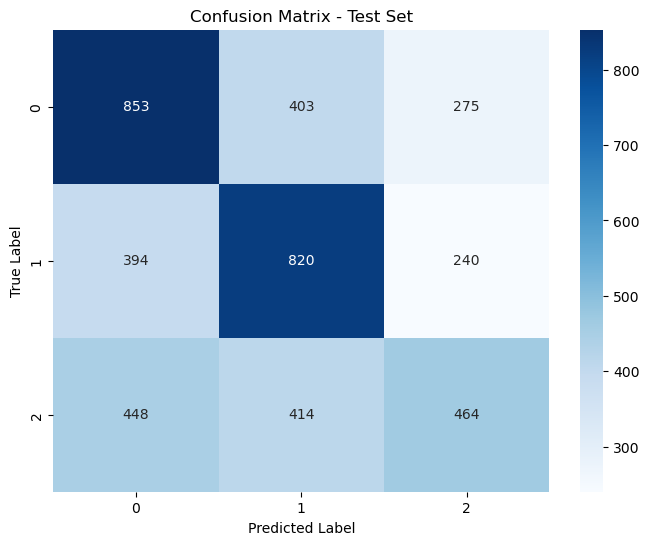


Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      1531
           1       0.50      0.56      0.53      1454
           2       0.47      0.35      0.40      1326

    accuracy                           0.50      4311
   macro avg       0.49      0.49      0.49      4311
weighted avg       0.49      0.50      0.49      4311


Metrics Comparison:
{'Validation': {'test_loss': 1.0124139785766602, 'test_cross_entropy_loss': 1.029211401939392, 'test_accuracy': 0.4957086522848527, 'test_precision': 0.4934521066426075, 'test_recall': 0.4957086522848527, 'test_f1': 0.49059194234923204, 'test_runtime': 220.3661, 'test_samples_per_second': 19.563, 'test_steps_per_second': 0.309}, 'Test': {'test_loss': 1.0124164819717407, 'test_cross_entropy_loss': 1.0292117595672607, 'test_accuracy': 0.4957086522848527, 'test_precision': 0.4934497465613974, 'test_recall': 0.4957086522848527, 'test_f1': 0.4905915827112744, 'te

In [13]:
# Evaluate on validation dataset
print("Evaluating validation dataset...")
eval_metrics = evaluate_and_visualize(trainer, eval_dataset, "Validation Set")

# Evaluate on test dataset
print("\nEvaluating test dataset...")
test_metrics = evaluate_and_visualize(trainer, test_dataset, "Test Set")

# Compare metrics
metrics_comparison = {
    'Validation': eval_metrics,
    'Test': test_metrics
}
print("\nMetrics Comparison:")
print(metrics_comparison)